# Training the model

In [141]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
from multiprocessing import cpu_count
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import _LRScheduler
import os
import pickle
import random
from random import randint
from sklearn.metrics import confusion_matrix, log_loss, matthews_corrcoef ## modified by Jason 0623
from time import strftime
from csv import writer
import shutil
import krippendorff as kd # need pip install krippendorff
# from torchvision.transforms import Normalize

In [152]:
######### general hyper-parameters
PU_LEARNING = True
LEN_MIN = 100 # the fixed seq length (in frame, and the data source is 25fps) of each training samples, the training sample smaller than this length will be filtered away
INTERVAL = 4 # it means sampling once for every XX data points, so the actual seq length becomes len_min/interval

DATA_PATH = Path("../data")
MODEL_PATH = Path("../model")    
DATA_FOLDER=Path('preprocessed/data_sample')

folder = [DATA_PATH / "train", DATA_PATH / "test", DATA_PATH / "val"] # the directories of train, test, and val dataset, NOTE THAT it requires preprocessed data, not raw data
# path_prior = DATA_PATH / "train" / "distribution.csv" # the file that stores training data label (0/1) distribution used for PULearning

TRAIN_TYPE = "latest" # define the type of training, choose 1 from {'latest', 'random', 'curri'}, see the details in def __getitem__(self, idx)
VAL_TYPES = ["human","latest"] # define the type of validation, choose 1 or more from {'latest', 'random', 'curri', 'human'}. Use '[]' even you only choose 1.  ## modified by Jason 0623
# note that only the first type in the val_types will be recorded in history.csv


######### 

In [144]:
######### model-related hyper-parameters
SAVENAME = 'c_b_19d_128_128_128_PU' # the name for the model
FEATURE_COL = np.arange(0,19) # this is to further select features after preprocessing. 
# e.g. if the feature after preprocessing is 19d, you may further select 17d from it.

bs = 64 # batch size
input_dim = len(FEATURE_COL)
conv1_dim = 128
conv2_dim = 128
lstm_dim = 128
layer_dim = 1
output_dim = 1
hidden1_dim = 128
hidden2_dim = 128

lr = 0.0002
n_epochs = 500
patience = 999
    
#########

In [145]:
def setseed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
setseed(0)
torch.cuda.set_device(0)  # choose the gpu_id you want to use

## Load the Data
First of all, we read the files and drop the irrelavant columns.

In [146]:
class MyDataset(Dataset): # curriculum learning
    def __init__(self, datapath, data_len, interval, sampling_type='random', start_pos=None, feature_col=FEATURE_COL):
        self.data_files = datapath
        self.interval = interval
        self.data_len = data_len # the expected length of each training sample
        self.epoch = 0 # current_epoch/max_epoch
        self.curriculum = sampling_type # {'latest', 'random', 'curri'}
        self.feature_col = feature_col
        self.start_pos = start_pos
    
    def __getitem__(self, idx): # this function takes a random interval from the range of x
        with open(self.data_files[idx], 'rb') as f:
            x_id, y_id, data = pickle.load(f)
            
        if self.start_pos:
            start = self.start_pos[idx]
        else:
            # get the end part from the data
            if self.curriculum == 'latest':
                start = len(data)-self.data_len

            # get a random part of the data
            elif self.curriculum == 'random':
                start = randint(0,len(data)-self.data_len)

            # gradually change from a to b according to current_epoch/max_epoch
            elif self.curriculum == 'curri': 
                tail = len(data)-self.data_len
                head = int(tail*(1-self.epoch))
                start = randint(head, tail)

            else:
                print(f"sampling type {self.curriculum} is not valid!")

        x = data[start:start+self.data_len:self.interval, self.feature_col]
        y = np.array([1.]) if x_id==y_id else np.array([0.])
        source_file = str(self.data_files[idx]) # this line is newly added
        return np.float32(x), y, source_file
        
    def __len__(self):
        return len(self.data_files)
    

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

def get_datapath(folder, data_folder):
    subfolder = [folder / f for f in os.listdir(folder) if not f.startswith('.') and os.path.isdir(folder / f)]
    subsubfolder = []
    for i in subfolder:
        if os.path.isdir(i / data_folder): 
            temp = [i / data_folder / f for f in os.listdir(i / data_folder) if not f.startswith('.') and os.path.isfile(i / data_folder / f)]
            subsubfolder = subsubfolder + temp
    return subsubfolder

def filterlength(datapath, data_len): # check data sample length and get label distribution (balance) in advance
    path = datapath[0].parents[3] # /data/{train, test, val}/
    filename = path / ".datapath_filtered" / ("data"+path.name+"_"+str(data_len))
    labelfile = path / ".datapath_filtered" / ("label"+path.name+"_"+str(data_len))

    if os.path.isfile(filename) and os.path.isfile(labelfile):
        with open(filename, 'rb') as f:
            datapath_filtered = pickle.load(f)
        with open(labelfile, 'rb') as f:
            label = pickle.load(f)
    else:  
        datapath_filtered=[]
        label=[]
        for i in datapath:
            with open(i, 'rb') as f:
                x_id, y_id, data = pickle.load(f)
            if len(data) >= data_len:
                datapath_filtered.append(i)
                y = 1 if x_id==y_id else 0
                label.append(y)
        os.makedirs(filename.parent, exist_ok=True)
        with open(filename, 'wb') as f:
            pickle.dump(datapath_filtered, f)
        with open(labelfile, 'wb') as f:
            pickle.dump(label, f)
        print("data filtered by length have been saved.")

    return datapath_filtered, label

def create_sampler(label): # create sample weights for data imbalance
    class_sample_count = np.array([label.count(0), label.count(1)])
    # Handling potential division by zero errors
    if class_sample_count[0] == 0 or class_sample_count[1] == 0:
        print("Error: One or both classes are missing in the labels.")
        return None
    
    weight = 1./class_sample_count
    samples_weight = np.array([weight[t] for t in label])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [147]:
print('Preparing datasets')

trn_datapath, trn_label = filterlength(get_datapath(folder[0], DATA_FOLDER),LEN_MIN)
val_datapath, val_label = filterlength(get_datapath(folder[2], DATA_FOLDER),LEN_MIN)

Preparing datasets


## Implementation of PU Loss
source: https://github.com/cimeister/pu-learning/blob/master/loss.py  
example: https://github.com/cimeister/pu-learning/blob/master/run_classifier.py

In [148]:
class PULoss(nn.Module):
    """wrapper of loss function for PU learning"""

    def __init__(self, prior, loss=(lambda x: torch.sigmoid(-x)), gamma=1, beta=0, nnPU=False):
        super(PULoss,self).__init__()
        if not 0 < prior < 1:
            raise NotImplementedError("The class prior should be in (0, 1)")
        self.prior = prior
        self.gamma = gamma
        self.beta = beta
        self.loss_func = loss #lambda x: (torch.tensor(1., device=x.device) - torch.sign(x))/torch.tensor(2, device=x.device)
        self.nnPU = nnPU
        self.positive = 1
        self.unlabeled = 0
        self.min_count = torch.tensor(1.)
    
    def forward(self, inp, target, test=False):
        assert(inp.shape == target.shape)        
        positive, unlabeled = target == self.positive, target == self.unlabeled
        positive, unlabeled = positive.type(torch.float), unlabeled.type(torch.float)
        if inp.is_cuda:
            self.min_count = self.min_count.cuda()
#             self.prior = self.prior.cuda()
        n_positive, n_unlabeled = torch.max(self.min_count, torch.sum(positive)), torch.max(self.min_count, torch.sum(unlabeled))
        
        y_positive = self.loss_func(positive*inp) * positive
        y_positive_inv = self.loss_func(-positive*inp) * positive
        y_unlabeled = self.loss_func(-unlabeled*inp) * unlabeled

        positive_risk = self.prior * torch.sum(y_positive)/ n_positive
        negative_risk = - self.prior *torch.sum(y_positive_inv)/ n_positive + torch.sum(y_unlabeled)/n_unlabeled

        if negative_risk < -self.beta and self.nnPU:
            return -self.gamma * negative_risk
        else:
            return positive_risk+negative_risk

Implementation of MbLS calibration  
source: https://github.com/by-liu/MbLS

In [154]:
# modified by Jason 0628
margin: float = 10
alpha: float = 0.1

def get_diff(inputs):
    max_values = inputs.max(dim=1)
    max_values = max_values.values.unsqueeze(dim=1).repeat(1, inputs.shape[1])
    diff = max_values - inputs
    return diff

# usage is as follows:
# diff = get_diff(INPUTS)  # INPUTS=logits
# loss_margin = F.relu(diff-margin).mean()
# loss = ANY_LOSS_YOU_ARE_USING + alpha*loss_margin

## create LSTM Model
Our classifier contains of several LSTM cells (hidden under the hood of nn.LSTM), and one nn.Linear layer. Note that we use batch_first=True to make sure that the first dimension of our tensors is interpreted as a batch size, and the next one - as a time dimension.

In [150]:
class ConvLSTMClassifier(nn.Module):
    
    def __init__(self, input_dim, conv1_dim, conv2_dim, lstm_dim, layer_dim, output_dim):
        super().__init__()
        self.lstm_dim = lstm_dim
        self.layer_dim = layer_dim
        self.cnn1 = nn.Conv1d(input_dim, conv1_dim, kernel_size=5, stride=2, padding=0)
        self.cnn2 = nn.Conv1d(conv1_dim, conv2_dim, kernel_size=5, stride=2, padding=0)
        self.bn1 = nn.BatchNorm1d(conv1_dim)
        self.bn2 = nn.BatchNorm1d(conv2_dim)
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.rnn = nn.LSTM(conv2_dim, lstm_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(lstm_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        x = x.permute(0, 2, 1) # swap dimension (1,2) because Conv1d requires (batch, feature, seq), where the LSTM input is (batch, seq, feature)
        x = self.cnn1(x)
        x = self.prelu1(self.bn1(x)) # bn-layer's input is (batch, feature, seq)
        x = self.dropout1(x)
        x = self.cnn2(x)
        x = self.prelu2(self.bn2(x))
        x = self.dropout2(x)
        x = x.permute(0, 2, 1) # now x is (batch, seq, feature)
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out4inference = out[:, -1, :]
        out = self.fc(out4inference)
        return out, out4inference
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.lstm_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.lstm_dim)
        return [t.cuda() for t in (h0, c0)]
    
# class LSTMClassifier(nn.Module):
#     """Very simple implementation of LSTM-based time-series classifier."""
    
#     def __init__(self, input_dim, hidden1_dim, hidden2_dim, layer_dim, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden1_dim)
#         self.bn = nn.BatchNorm1d(hidden1_dim)
#         self.prelu = nn.PReLU()
#         self.rnn = nn.LSTM(hidden1_dim, hidden2_dim, layer_dim, batch_first=True, bidirectional=False)
#         self.fc2 = nn.Linear(hidden2_dim, output_dim)
    
#     def forward(self, x): # input is (batch, seq, feature)
#         x = self.fc1(x)
#         x = x.permute(0, 2, 1) # bn layer expects input of (batch, feature, seq)
#         x = self.prelu(self.bn(x)) 
#         x = x.permute(0, 2, 1) # lstm layer expects input of (batch, seq, feature)
#         out, (hn, cn) = self.rnn(x)
#         out4inference = out[:, -1, :]
#         out = self.fc2(out4inference)
#         return out,out4inference

## Training Loop
Finally, we are ready to bring everything together and train the model.

In [151]:
def my_plot(epochs, loss, loss_val, filename):
    num_subplots = len(loss_val)+1
    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 2*num_subplots))
    ax = axes[0]
    ax.plot(epochs, loss, 'bo-')
    ax.set_xlabel('epoch')
    ax.set_ylabel('train loss')
    i=1
    for key, value in loss_val.items():
        ax = axes[i]
        i+=1
        ax.plot(epochs, value, 'ro-')
        ax.set_xlabel('epoch')
        ax.set_ylabel('val loss '+key)
    plt.tight_layout()
    if filename:
        plt.savefig(MODEL_PATH / SAVENAME / (filename+".pdf"), format="pdf", bbox_inches="tight")
    plt.show()

        
def write_csv(filepath, cm_train, cm_val, loss_train, loss_val):
    n=cm_val.sum()
    TN_val = cm_val[0][0]/n
    FN_val = cm_val[1][0]/n
    TP_val = cm_val[1][1]/n
    FP_val = cm_val[0][1]/n
    acc_val = TN_val+TP_val
    N=cm_train.sum()
    TN_train = cm_train[0][0]/N
    FN_train = cm_train[1][0]/N
    TP_train = cm_train[1][1]/N
    FP_train = cm_train[0][1]/N
    acc_train = TN_train+TP_train
    row = [loss_train,acc_train,TP_train,FP_train,TN_train,FN_train,loss_val,acc_val,TP_val,FP_val,TN_val,FN_val]
    with open(filepath, 'a', newline='') as f:
        csv_writer = writer(f)
        csv_writer.writerow(map(lambda t: "%.4f" % t, row))  

## ----------- modified by Jason 0623 ----------- 
def model_eval(val_dl):
    model.eval()
    correct, total = 0, 0
    cm_val = np.array([[0,0],[0,0]])
    running_loss = 0.0
    y_preds,y_label=[],[]

    for x_val, y_val, _ in val_dl:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out,_ = model(x_val)
        preds = torch.sigmoid(out)>0.5
        total += y_val.size(0)
        # correct += (preds == y_val).sum().item()
        cm_val += confusion_matrix(y_val.cpu(), preds.cpu())
        loss_val = criterion(out, y_val)
        diff = get_diff(out) # modified by Jason 0628
        loss_val += alpha*F.relu(diff-margin).mean() # modified by Jason 0628 
        running_loss += loss_val.item() * y_val.shape[0]
        y_preds+=preds.cpu().detach().flatten().tolist()
        y_label+=y_val.cpu().detach().flatten().tolist()

    epoch_loss = running_loss/total 
    acc = np.mean(y_preds == y_label)
    mcc = matthews_corrcoef(y_label, y_preds)    
    return epoch_loss, mcc, cm_val
## ----------- modified by Jason 0623 ----------- 

def add2dict(dictionary, key, value):
    if key not in dictionary:
        dictionary[key] = [value]
    elif type(dictionary[key]) == list:
        dictionary[key].append(value)
    else:
        dictionary[key] = [dictionary[key], value]

In [155]:
if not SAVENAME:
    SAVENAME = 'temp'
(MODEL_PATH / SAVENAME).mkdir(parents=True, exist_ok=True)

best_acc = 0
trials = 0
epoch_loss=[]
epoch_loss_val={}
acc, cm_val = {}, {}
val_ds, val_dl = {}, {}

model = ConvLSTMClassifier(input_dim, conv1_dim, conv2_dim, lstm_dim, layer_dim, output_dim)
model = model.cuda()

if PU_LEARNING:
    criterion = PULoss(prior=0.164, nnPU=True)
    # modified by Jason 0628
else:
    criterion = nn.BCEWithLogitsLoss() # nn.CrossEntropyLoss() # bug: change to binary entropy loss

opt = torch.optim.RAdam(model.parameters(), lr=lr)
sched=None

timestr = strftime("%Y%m%d-%H%M%S")
filepath = MODEL_PATH / SAVENAME / ("history_"+timestr+'.csv')# for saving history
field_names = ['loss_train','acc_train','TP_train','FP_train','TN_train','FN_train','loss_val','acc_val','TP_val','FP_val','TN_val','FN_val']
with open(filepath, 'a', newline='') as f:
    csv_writer = writer(f)
    csv_writer.writerow(field_names)
    
trn_ds   = MyDataset(trn_datapath, data_len=LEN_MIN, interval=INTERVAL, sampling_type=TRAIN_TYPE)
trn_dl   = DataLoader(trn_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=create_sampler(trn_label))

for val_type in VAL_TYPES:
    ## ----------- modified by Jason 0623 ----------- 
    if val_type == 'human':
        mode = 'val' 
        csv_path = DATA_PATH / 'human_annotation' / ('vimeo_'+mode) / 'test_result.csv'
        df=pd.read_csv(csv_path)
        start_pos = df["start_pos"].values.tolist()
        data_id = df["data_id"].values.tolist()
        file_id = df["file_id"].values.tolist()
        datapath = [DATA_PATH / 'human_annotation' / ('vimeo_'+mode) / (mode+'_vimeo_'+ str(i)) / 'data_sample' / str(j) for (i,j) in zip(file_id, data_id)]
        non_nan_index = df.index[df['result'].notna()]
        feature_col_annotation = np.append(np.arange(1, 3), np.arange(179, 196)) 
        val_ds[val_type] = MyDataset(datapath, data_len=LEN_MIN, interval=INTERVAL, start_pos=start_pos, feature_col=feature_col_annotation) 
        val_dl[val_type] = DataLoader(val_ds[val_type], batch_size=1, shuffle=False, num_workers=0, sampler=None)
        value_mapping = {'want_speak': 1, 'if_speak': 1, 'other': 0} # adjust 'if_speak' here to 0 or 1
        label_human = df['result'][non_nan_index].map(value_mapping).values # human annotator majority voting
    else:
    ## ----------- modified by Jason 0623 -----------     
        val_ds[val_type] = MyDataset(val_datapath, data_len=LEN_MIN, interval=INTERVAL, sampling_type=val_type)
        val_dl[val_type] = DataLoader(val_ds[val_type], batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=create_sampler(val_label))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    setseed(epoch)
    
    trn_ds.epoch = epoch/n_epochs
    for val_type in VAL_TYPES:
        val_ds[val_type].epoch = epoch/n_epochs
    
    cm_train = np.array([[0,0],[0,0]])
    running_loss = 0.0
    
    for i, (x_batch, y_batch, _) in enumerate(trn_dl):
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out,_ = model(x_batch)
        preds = torch.sigmoid(out)>0.5
        loss = criterion(out, y_batch)
        diff = get_diff(out) # modified by Jason 0628
        loss += alpha*F.relu(diff-margin).mean() # modified by Jason 0628 
        loss.backward()
        opt.step()
        cm_train += confusion_matrix(y_batch.cpu(), preds.cpu())
        running_loss += loss.item() * y_batch.shape[0]         
                
    epoch_loss.append(running_loss / len(trn_ds))
    
    #### validation ####

    for val_type in VAL_TYPES:
        ## ----------- modified by Jason 0623 ----------- 
        if val_type == 'human':
            preds=[]
            model.eval()
            for x_val, y_val, sourcefile in val_dl[val_type]:
                x_val, y_val = [t.cuda() for t in (x_val, y_val)]
                out, out4inference = model(x_val)
                pred = torch.sigmoid(out)
                pred = pred.cpu().detach().flatten().tolist()
                # preds.append(pred[0][0])
                preds += pred
            preds = np.array(preds)[non_nan_index]
            loss_temp = log_loss(label_human, preds) # here the loss is purely BCEloss based on human labels
            preds = preds > 0.5
            cm_val[val_type] = confusion_matrix(label_human, preds)            
            mcc = matthews_corrcoef(label_human, preds)
            # acc[val_type] = np.mean(preds == label_human)
            acc[val_type] = mcc # use mcc instead of accuracy
            add2dict(epoch_loss_val, val_type, loss_temp)
        else:
        ## ----------- modified by Jason 0623 ----------- 
            setseed(0)
            loss_temp, acc[val_type], cm_val[val_type] = model_eval(val_dl[val_type])
            add2dict(epoch_loss_val, val_type, loss_temp)
    
    #### save log ####
    
    write_csv(filepath=filepath, cm_train=cm_train, cm_val=next(iter(cm_val.values())), loss_train=epoch_loss[-1], loss_val=next(iter(epoch_loss_val.values()))[-1])

    if epoch % 10 == 0:
        acc_print = ", ".join([f"{key}: {value:.4}" for key, value in acc.items()])  ## modified by Jason 0623
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss[-1]:.4f}. MCC: {acc_print}')  ## modified by Jason 0623

    acc_max = max(acc.values(), key=lambda x: max(x) if isinstance(x, list) else x)
    if acc_max > best_acc:
        trials = 0
        best_acc = acc_max
        torch.save(model.state_dict(), MODEL_PATH / SAVENAME / 'best.pth')
        print(f'Epoch {epoch} best model saved with MCC: {best_acc:.4}')  ## modified by Jason 0623
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
        
torch.save(model.state_dict(), MODEL_PATH / SAVENAME / 'last.pth') 

Start model training
Epoch 1 best model saved with MCC: 0.07788
Epoch:  10. Loss: 0.4544. MCC: human: -0.003663, latest: -0.003098
Epoch 11 best model saved with MCC: 0.08332
Epoch 13 best model saved with MCC: 0.09602
Epoch:  20. Loss: 0.3284. MCC: human: -0.09032, latest: -0.08228
Epoch:  30. Loss: 0.1673. MCC: human: -0.03539, latest: -0.06921
Epoch:  40. Loss: 0.1116. MCC: human: -0.008006, latest: -0.06921
Epoch:  50. Loss: 0.1036. MCC: human: -0.03539, latest: -0.0559
Epoch:  60. Loss: 0.1623. MCC: human: -0.04892, latest: -0.01531
Epoch:  70. Loss: 0.1035. MCC: human: -0.007075, latest: -0.0282
Epoch:  80. Loss: 0.1092. MCC: human: -0.03324, latest: 0.09688
Epoch 80 best model saved with MCC: 0.09688
Epoch 81 best model saved with MCC: 0.1408
Epoch:  90. Loss: 0.1132. MCC: human: -0.01652, latest: 0.03822
Epoch 93 best model saved with MCC: 0.1546
Epoch: 100. Loss: 0.0707. MCC: human: -0.009364, latest: 0.1259
Epoch: 110. Loss: 0.0467. MCC: human: -0.1271, latest: -0.04787
Epoch

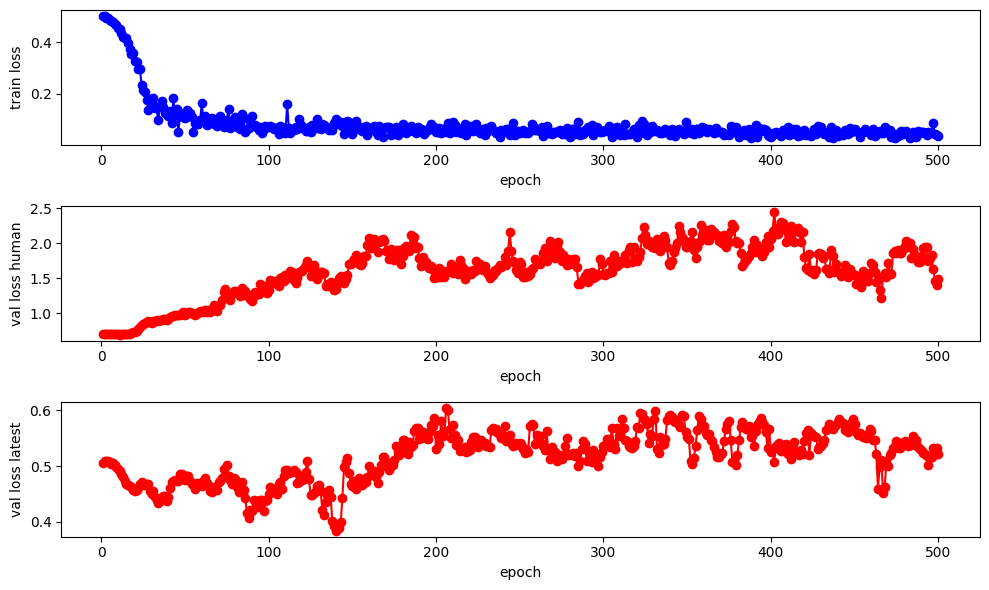

In [158]:
my_plot(np.arange(1, epoch+1), epoch_loss, epoch_loss_val, filename='Loss')   

# Evaluation

## use t-SNE to visualize features

In [14]:
def load_model():
    model = ConvLSTMClassifier(input_dim, conv1_dim, conv2_dim, lstm_dim, layer_dim, output_dim)
    model = model.cuda()
    model_file = MODEL_PATH / SAVENAME / (whichmodel+'.pth')
    model.load_state_dict(torch.load(model_file))
    model.eval()

def scale_to_01_range(x): # scale and move the coordinates so they fit [0; 1] range
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

def plot_tSNE(ax, classname, tsne):
    keys = list(np.unique(classname))
    NUM_COLORS = len(keys)
    cm = plt.get_cmap('gist_rainbow')
    values = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    colors_per_class = dict(zip(keys, values))

    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = scale_to_01_range(tsne[:, 0])
    ty = scale_to_01_range(tsne[:, 1])
    
    # for every class, we'll add a scatter plot separately
    for label in reversed(list(colors_per_class.keys())):
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(classname) if l == label]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        # convert the class color to matplotlib format
        color = colors_per_class[label]

        # add a scatter plot with the corresponding color and label
        ax.scatter(current_tx, current_ty, color=color, label=label, s=10)

    # build a legend using the labels we set previously
    ax.legend(loc='upper right', bbox_to_anchor=(.99, .99))

def calculate_tSNE(model, dl, pdfname):
    flag = 0
    for x_val, y_val, sourcefile in dl: # I need x_val, y_val, frame_idx here for visualization
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out, out4inference = model(x_val) # (batch_size, 16)
        pred = torch.sigmoid(out)>0.5
        pred = pred.cpu().detach().numpy()
        feature = out4inference.cpu().detach().numpy()
        label = y_val.cpu().numpy()
        source = list(sourcefile)
        if flag == 0:
            features = feature
            labels = label
            preds = pred
            sources = source
            flag+=1
        else:
            features = np.concatenate((features,feature))
            labels = np.concatenate((labels,label))
            preds = np.concatenate((preds,pred))
            sources += source

    # print(features.shape, labels.shape, preds.shape, len(sources))
    
    setseed(0)
    tsne = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(features)
    
    classname1=[]
    for j in range(len(sources)):
        filename = Path(sources[j]).parent.parent.parent.name
        classname1.append(str(filename))

    classname2=[]
    for j in range(len(sources)):
        if labels[j] == 1:
            classname2.append("label=1")
        elif preds[j] == 1:
            classname2.append("label=0, pred=1")
        elif preds[j] == 0:
            classname2.append("label=0, pred=0")
        else:
            print("undefined class")


    # initialize a matplotlib plot
    fig, axes = plt.subplots(1,2, figsize=(16,7))
    plot_tSNE(axes[0], classname1, tsne)
    plot_tSNE(axes[1], classname2, tsne)
    plt.savefig(MODEL_PATH / SAVENAME / pdfname, format="pdf", bbox_inches="tight")
    plt.show()

In [34]:
from sklearn.manifold import TSNE

# # modify LSTM hyper-parameters here if you want to use a saved model,
# # no need to modify if you want to use a model just trained above

# SAVENAME = 'c_b_19d_128_128_128_PU'
# FEATURE_COL = np.arange(0,19)
# input_dim = len(FEATURE_COL)
# conv1_dim = 128
# conv2_dim = 128
# lstm_dim = 128
# layer_dim = 1
# output_dim = 1
# hidden1_dim = 128
# hidden2_dim = 128

whichmodel = 'best' # {‘best', 'last'} 
sampling_type = 'latest' # {'latest', 'random'}

val_ds = MyDataset(val_datapath, data_len=LEN_MIN, interval=INTERVAL, sampling_type=sampling_type)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=None)
trn_ds = MyDataset(trn_datapath, data_len=LEN_MIN, interval=INTERVAL, sampling_type=sampling_type)
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=None)

load_model()

C:\Users\jiaxin.ma\AppData\Local\conda\conda\envs\remote-meeting\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


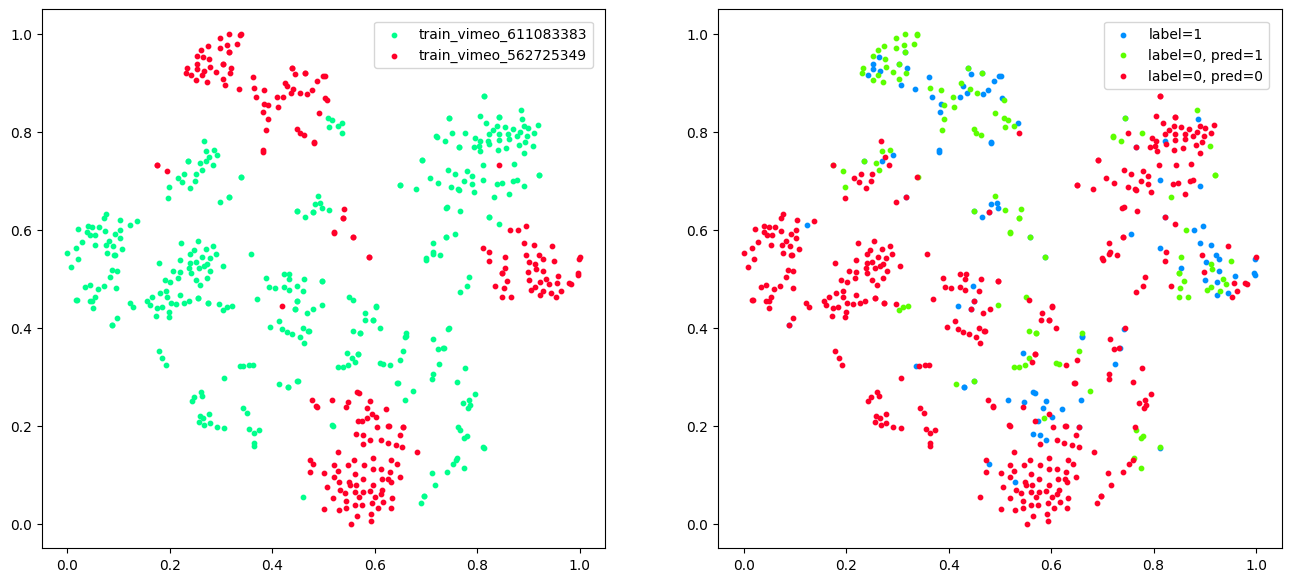

C:\Users\jiaxin.ma\AppData\Local\conda\conda\envs\remote-meeting\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


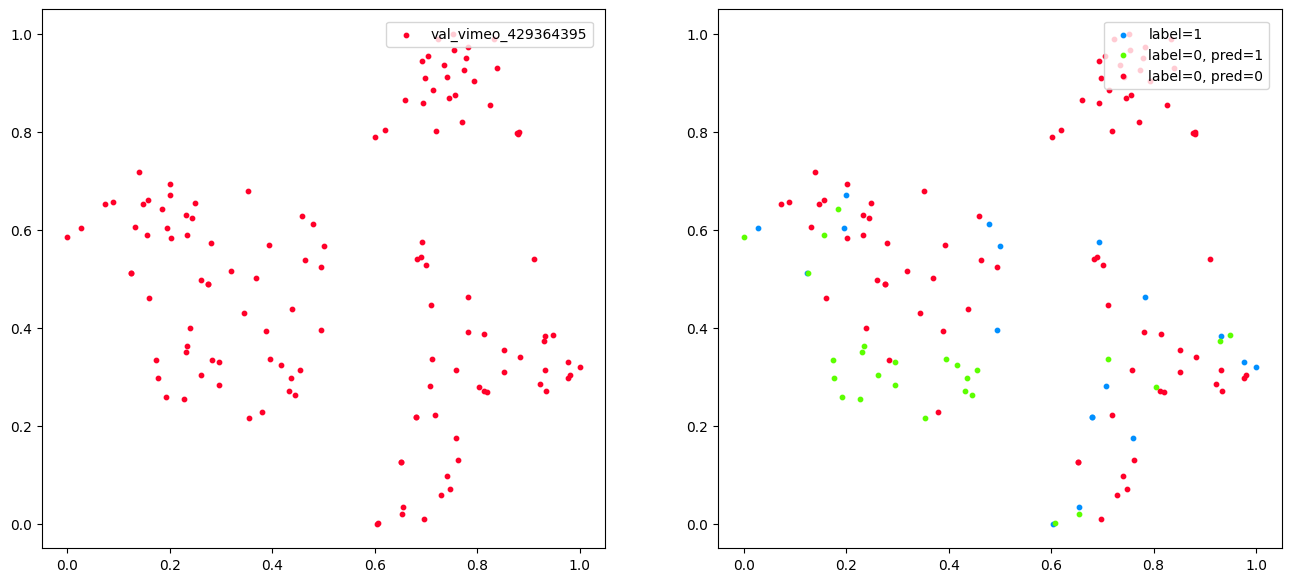

In [35]:
calculate_tSNE(model, trn_dl, "tSNE_train.pdf")
calculate_tSNE(model, val_dl, "tSNE_val.pdf")

## Evaluation on human annotation  
modified by Jason 0623

In [121]:
mode = 'val' 
csv_path = DATA_PATH / 'human_annotation' / ('vimeo_'+mode) / 'test_result.csv'
df=pd.read_csv(csv_path)
start_pos = df["start_pos"].values.tolist()
data_id = df["data_id"].values.tolist()
file_id = df["file_id"].values.tolist()
datapath = [DATA_PATH / 'human_annotation' / ('vimeo_'+mode) / (mode+'_vimeo_'+ str(i)) / 'data_sample' / str(j) for (i,j) in zip(file_id, data_id)]
non_nan_index = df.index[df['result'].notna()]

feature_col_annotation = np.append(np.arange(1, 3), np.arange(179, 196)) 
# 19d feature (here the data_sample for human annotation are preprocessed by an old-version script, so the feature index is different)

ds = MyDataset(datapath, data_len=LEN_MIN, interval=INTERVAL, start_pos=start_pos, feature_col=feature_col_annotation) 
dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, sampler=None)

In [122]:
# # modify LSTM hyper-parameters here if you want to use a saved model,
# # no need to modify if you want to use a model just trained above

# SAVENAME = 'c_b_19d_128_128_128_PU'
# input_dim = len(feature_col_annotation)
# conv1_dim = 128
# conv2_dim = 128
# lstm_dim = 128
# layer_dim = 1
# output_dim = 1
# hidden1_dim = 128
# hidden2_dim = 128

whichmodel = 'best' # {‘best', 'last'} 
load_model()

In [124]:
preds=[]
for x_val, y_val, sourcefile in dl:
    x_val, y_val = [t.cuda() for t in (x_val, y_val)]
    out, out4inference = model(x_val)
    pred = torch.sigmoid(out)
    pred = pred.cpu().detach().flatten().tolist()
    preds+=pred
preds = np.array(preds)[non_nan_index]>0.5

### caculate Matthews correlation coefficient (MCC) between any two annotators (or model)
### calculate krippendorff's alpha between any N (N>=2) annotators (or model)

In [159]:
value_mapping = {'want_speak': 1, 'if_speak': 0, 'other': 0} 
# change the value_mapping here, 'if_speak' should be either 0 or 1.
# theoretically 'if_speak' can be float value between 0~1. But MCC and kd-alpha only support binary or multiclass labels.

label0 = preds # model prediction
label1 = df['label_1'][non_nan_index].map(value_mapping).values # human annotator 1
label2 = df['label_2'][non_nan_index].map(value_mapping).values # human annotator 2
label3 = df['label_3'][non_nan_index].map(value_mapping).values # human annotator 3
label4 = df['result'][non_nan_index].map(value_mapping).values # human annotator majority voting
label5 = df["label_ASD"][non_nan_index] # ASD

In [160]:
arr = np.array(label4)

counts = np.bincount(arr)
zeros = counts[0]
ones = counts[1]

print("Number of zeros:", zeros)
print("Number of ones:", ones)

Number of zeros: 163
Number of ones: 32


In [126]:
matthews_corrcoef(label1, label2)

0.3534249942186554

In [81]:
kd.alpha(np.vstack((label1, label2, label3)), level_of_measurement='nominal')

0.31294117647058817

# Export the model to .onnx file

In [98]:
dummy_input = torch.randn(x_val[:1,:].shape).cuda()
export_path = '../model/exported_model.onnx'

torch.onnx.export(model, dummy_input, export_path, verbose=True,
                  input_names=["input"], output_names=["output"],
                  opset_version=11) # output model only accept batch_size=1

In [131]:
print(model)

ConvLSTMClassifier(
  (cnn1): Conv1d(19, 128, kernel_size=(5,), stride=(2,))
  (cnn2): Conv1d(128, 128, kernel_size=(5,), stride=(2,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (prelu2): PReLU(num_parameters=1)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
